# Zonal SST

**GOAL**:  
The goal of this file is to quantitatively evaluate and visualize the Root Mean Square Error (RMSE) of SST from multiple model configurations against observations in defined regions.

---

## Imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, List

# Constants

In [2]:
# --- Oceanic Region Definitions ---
region_defs: Dict[str, Tuple[float, float, float, float]] = {
    "Equatorial Pacific W": (-5, 5, 120, 180),
    "Equatorial Pacific E": (-5, 5, 180, 290),
    "Southern Ocean": (-65, -50, 0, 360),
    "Southwest Atlantic": (-50, -30, 300, 330),
    "Agulhas Return": (-45, -35, 0, 60),
    "Peru/Chile Upwelling": (-25, 0, 270, 285),
    "West Africa Upwelling": (-30, 5, 0, 15),
    "Kuroshio Extension": (35, 45, 142, 170),
    "Gulf Stream Extension": (35, 55, 285, 330),
    "Labrador Sea": (55, 65, 300, 330),
}
region_names: List[str] = list(region_defs.keys())
region_labels: List[str] = region_names

# --- Configuration Settings ---
cfgs: List[str] = [
    "00", "01", "02", "04", "05", "06", "07", "08", "09", "10", "12", "14", "15", "16", "17"
]
cfg_descriptions: List[str] = [
    "Benchmark",               # 00
    "Advection scheme",        # 01
    "Advection scheme",        # 02
    # "Surface current feedback",  # 03 (skipped)
    "Diffusion coefficient",   # 04
    "Advection scheme",        # 05
    "Diffusion coefficient",   # 06
    "Diffusion coefficient",   # 07
    "Lateral diffusion",       # 08
    "Lateral diffusion",       # 09
    "Lateral diffusion",       # 10
    "Lateral diffusion",       # 12
    "Surface current feedback",# 14
    "Lateral diffusion",       # 15
    "Physics",                 # 16
    "Physics",                 # 17
]

# --- Region Colors ---
region_colors: List[str] = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b",
    "#d62728", "#17becf", "#e377c2", "#bcbd22", "#20b2aa"
]

## Helper function

In [3]:
def wrap_longitude(lon):
    """Convert longitude(s) to the [-180, 180) range.

    Args:
        lon (float | np.ndarray | list): Input longitude or array of longitudes (in degrees).

    Returns:
        np.ndarray: Longitude(s) wrapped to [-180, 180).
    """
    return ((np.asarray(lon) + 180) % 360) - 180

## Main function

In [6]:
def plot_rmse(include_absolute_rmse_plot: bool = True) -> None:
    """Plot RMSE for each configuration and region, with optional absolute RMSE and always a relative RMSE panel.

    Args:
        include_absolute_rmse_plot (bool): If True, include absolute RMSE bar plot panel.
    """
    obs = xr.open_dataset("../../data/processed/combined_observations.nc")
    rmse_results = {cfg: [] for cfg in cfgs}

    # --- Loop over configs and regions to compute RMSE ---
    for cfg in cfgs:
        ds = xr.open_dataset(f"../../data/processed/nemo{cfg}.nc")
        error = ds['sst'] - obs['sst']
        rmse_points = []
        for lat_min, lat_max, lon_min, lon_max in region_defs.values():
            region_error = error.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
            rmse = np.sqrt((region_error ** 2).mean())
            rmse_points.append(float(rmse.values))
        rmse_results[cfg] = rmse_points
        ds.close()

    rmse_matrix = np.array([rmse_results[cfg] for cfg in cfgs])

    # --- Prepare error map for '00' configuration ---
    ds_00 = xr.open_dataset(f"../../data/processed/nemo00.nc")
    error_00 = ds_00['sst'] - obs['sst']
    if 'month' in error_00.dims:
        error_map = error_00.mean('month')
    else:
        error_map = error_00
    ds_00.close()

    # Convert longitudes to -180..180 if needed
    if (error_map.lon > 180).any():
        error_map = error_map.assign_coords(lon=wrap_longitude(error_map.lon))
        error_map = error_map.sortby('lon')

    # --- Figure and gridspec logic ---
    n_subplots = 3 if include_absolute_rmse_plot else 2
    if include_absolute_rmse_plot:
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 1, height_ratios=[1.5, 2, 1])
    else:
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(2, 1, height_ratios=[1.5, 2])

    # --- Plot: Error Map with regions ---
    ax_map = fig.add_subplot(gs[0], projection=ccrs.Mollweide())
    ax_map.set_global()
    ax_map.coastlines()
    ax_map.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax_map.gridlines(draw_labels=True, linestyle=':', linewidth=0.5, alpha=0.5)

    lon2d, lat2d = np.meshgrid(error_map.lon, error_map.lat)
    pcm = ax_map.pcolormesh(
        lon2d, lat2d, error_map.values,
        cmap="RdBu_r",
        vmin=-4, vmax=4,
        transform=ccrs.PlateCarree()
    )
    cbar = plt.colorbar(pcm, ax=ax_map, orientation="vertical", shrink=0.6, pad=0.03)
    cbar.set_label("SST Error (model - obs, °C)")

    for i, (label, (lat_min, lat_max, lon_min, lon_max)) in enumerate(region_defs.items()):
        color = region_colors[i]
        if label == "Southern Ocean" and lon_min == 0 and lon_max == 360:
            rect = Rectangle((-180, lat_min), 360, lat_max - lat_min,
                             linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
            ax_map.add_patch(rect)
            ax_map.text(0, lat_max + 2, label,
                        transform=ccrs.PlateCarree(), fontsize=9, ha='center', color=color)
        else:
            lon_min_wrapped = wrap_longitude(lon_min)
            lon_max_wrapped = wrap_longitude(lon_max)
            if lon_max_wrapped < lon_min_wrapped:
                width1 = 180 - lon_min_wrapped
                rect1 = Rectangle((lon_min_wrapped, lat_min), width1, lat_max-lat_min,
                                  linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
                ax_map.add_patch(rect1)
                width2 = lon_max_wrapped + 180
                rect2 = Rectangle((-180, lat_min), width2, lat_max-lat_min,
                                  linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
                ax_map.add_patch(rect2)
                label_lon = wrap_longitude((lon_min + lon_max) / 2)
                ax_map.text(label_lon, lat_max + 2, label,
                            transform=ccrs.PlateCarree(), fontsize=9, ha='center', color=color)
            else:
                width = lon_max_wrapped - lon_min_wrapped
                rect = Rectangle((lon_min_wrapped, lat_min), width, lat_max - lat_min,
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
                ax_map.add_patch(rect)
                ax_map.text((lon_min_wrapped + lon_max_wrapped) / 2, lat_max + 2, label,
                            transform=ccrs.PlateCarree(), fontsize=9, ha='center', color=color)

    # --- Plot: RMSE Bar Plot (ABSOLUTE) ---
    if include_absolute_rmse_plot:
        ax1 = fig.add_subplot(gs[1])
        n_cfg = len(cfgs)
        n_aspects = len(region_labels)
        x = np.arange(n_cfg)
        bar_width = 0.1

        for i, label in enumerate(region_labels):
            offset = -((n_aspects - 1) / 2) * bar_width + i * bar_width
            color = region_colors[i]
            ax1.bar(x + offset, rmse_matrix[:, i], bar_width, label=label, color=color)

        ax1.set_xticks(x)
        ax1.set_xticklabels([])
        ax1.set_xlabel("")
        ax1.set_ylabel("RMSE (SST)")
        ax1.set_title("RMSE per Region")
        legend_handles = [
            Patch(color=region_colors[i], label=region_names[i]) for i in range(len(region_names))
        ]
        ax1.legend(handles=legend_handles, title="Region", bbox_to_anchor=(1.01, 1))
        ax1.grid(axis='y', linestyle=':', alpha=0.5)

        for xi in x:
            ax1.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)

    # --- Plot: Relative RMSE Plot (ALWAYS INCLUDED) ---
    idx_00 = cfgs.index("00")
    rmse_00 = rmse_matrix[idx_00]
    threshold = 10

    all_pcts = []
    n_cfg = len(cfgs)
    n_aspects = len(region_labels)
    x = np.arange(n_cfg)
    bar_width = 0.1
    for i in range(n_aspects):
        for j in range(n_cfg):
            ref = rmse_00[i]
            val = rmse_matrix[j, i]
            pct = 0.0 if ref == 0 else (val - ref) / ref * 100
            all_pcts.append(pct)
    max_pct = max(abs(np.nanmin(all_pcts)), abs(np.nanmax(all_pcts)), 10)

    if include_absolute_rmse_plot:
        ax2 = fig.add_subplot(gs[2])
    else:
        ax2 = fig.add_subplot(gs[1])

    for i, label in enumerate(region_labels):
        offset = -((n_aspects - 1) / 2) * bar_width + i * bar_width
        base_color = region_colors[i]
        for j in range(n_cfg):
            ref = rmse_00[i]
            val = rmse_matrix[j, i]
            pct = 0.0 if ref == 0 else (val - ref) / ref * 100

            if cfgs[j] == "00":
                ax2.bar(j + offset, 0, bar_width, color="grey", edgecolor='black', zorder=1)
            elif abs(pct) <= threshold:
                ax2.bar(j + offset, pct, bar_width, color="grey", edgecolor='black', zorder=1)
            else:
                ax2.bar(j + offset, np.sign(pct) * threshold, bar_width, color="grey", edgecolor='black', zorder=1)
                ax2.bar(j + offset, pct - np.sign(pct) * threshold, bar_width,
                        color=base_color, bottom=np.sign(pct) * threshold, edgecolor='black', zorder=2)

    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_xticks(x)
    ax2.set_xticklabels(cfgs)
    ax2.set_xlabel("")
    ax2.set_ylabel("ΔRMSE vs '00' (%)")
    ax2.set_title("Relative RMSE Change per Region (±10% grey, others in region color)")
    ax2.set_ylim(-max_pct-10, max_pct+10)
    ax2.grid(axis='y', linestyle=':', alpha=0.5)

    for xi in x:
        ax2.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)

    for j, desc in enumerate(cfg_descriptions):
        ax2.text(j, -max_pct-20, desc, rotation=90, fontsize=9, va='top', ha='center')

    legend_elements = [
        Patch(facecolor='grey', edgecolor='black', label='Within ±10% or 00')
    ]
    for i, label in enumerate(region_labels):
        legend_elements.append(Patch(facecolor=region_colors[i], edgecolor='black', label=f'{label}'))

    ax2.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1.01, 0.25))

    plt.tight_layout()
    #plt.savefig("zonal_sst.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

## Function call

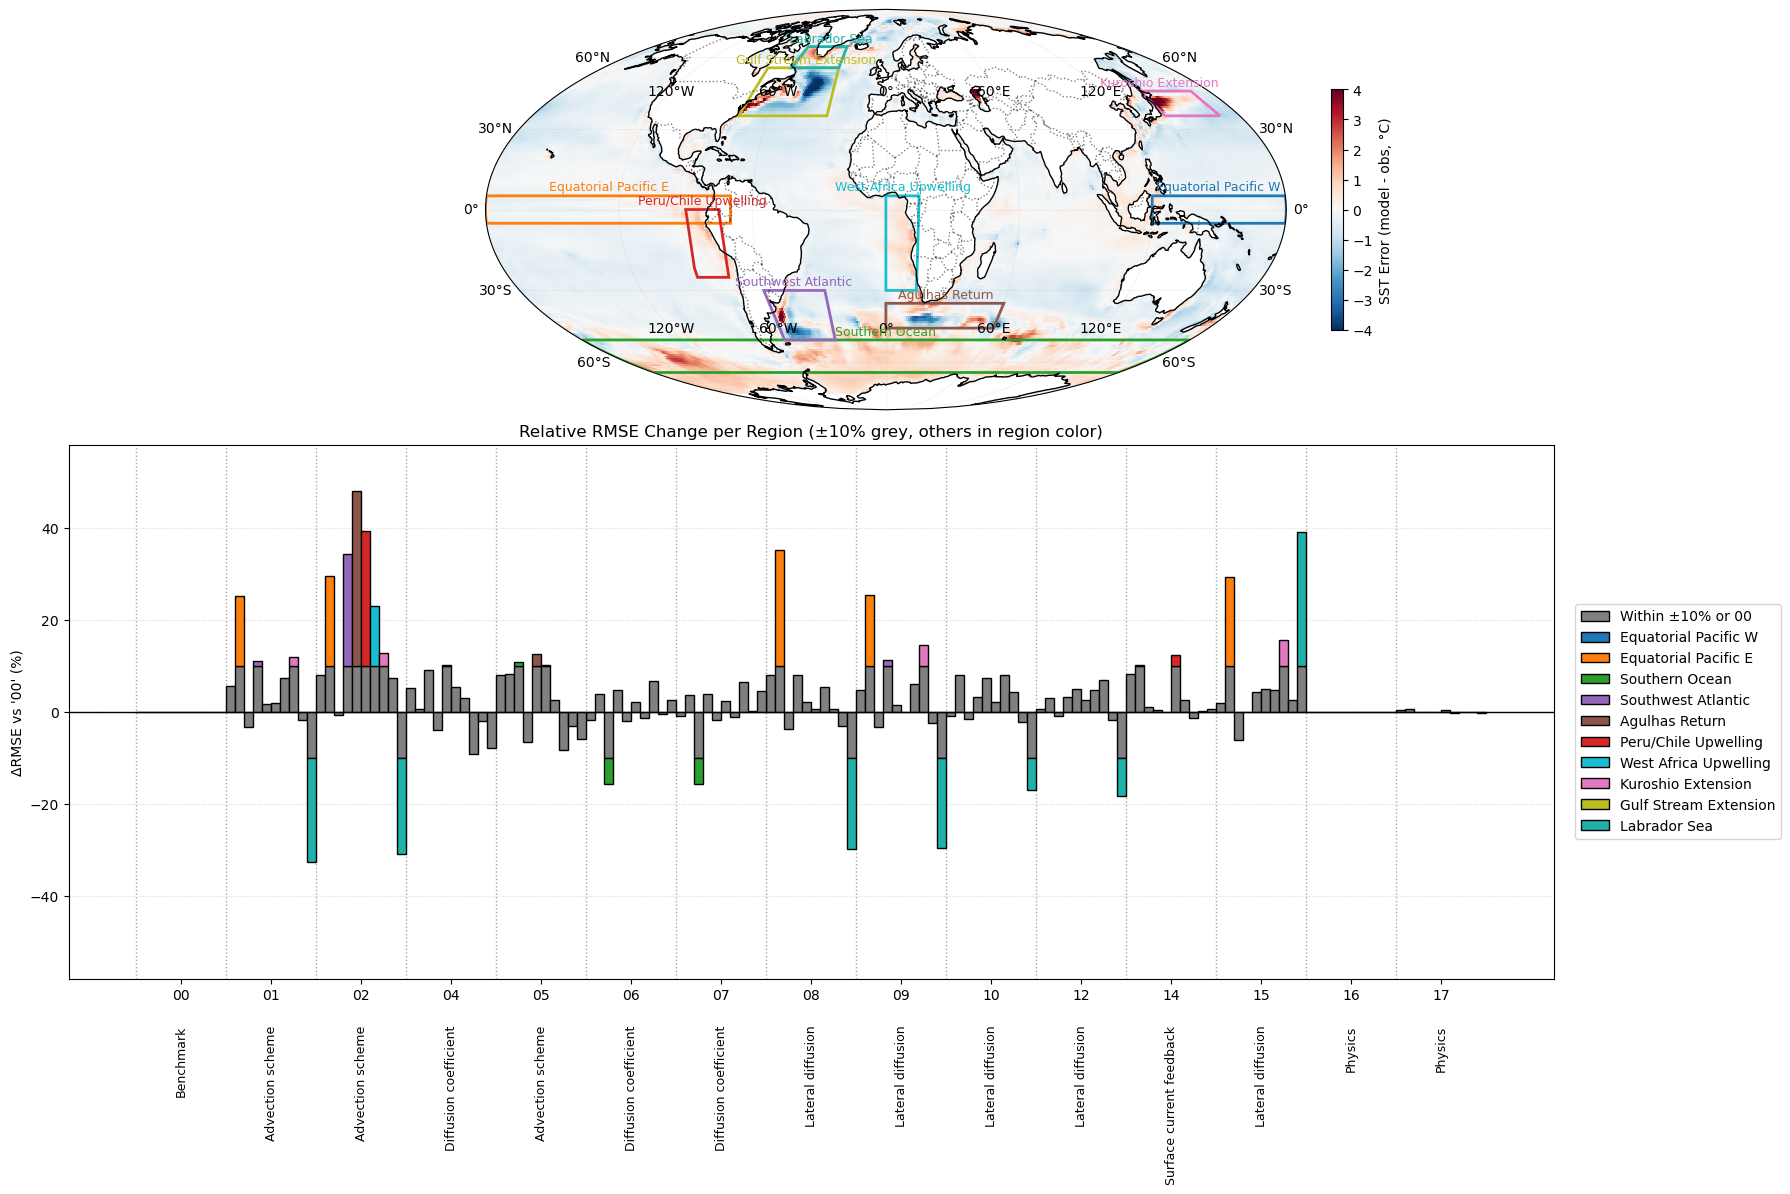

In [7]:
#plot_rmse(include_absolute_rmse_plot=True)  # Include absolute RMSE bar plot
plot_rmse(include_absolute_rmse_plot=False)  # Exclude absolute RMSE bar plot